# Fingerprint Authentication

This tutorial demonstrates how to use a machine learning model to generate a unique signature from a grayscale image of a fingerprint. The generated signature can then be compared against previously generated signatures stored in flash memory to authenticate users.

## Quick Links

- [GitHub Source](https://github.com/SiliconLabs/mltk/blob/master/mltk/tutorials/fingerprint_authentication.ipynb) - View this tutorial on Github
- [Run on Colab](https://colab.research.google.com/github/siliconlabs/mltk/blob/master/mltk/tutorials/fingerprint_authentication.ipynb) - Run this tutorial on Google Colab
- [C++ Example Application](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/fingerprint_authenticator.html) - View this tutorial's associated C++ example application
- [Machine Learning Model](https://siliconlabs.github.io/mltk/docs/python_api/models/siliconlabs/fingerprint_signature_generator.html) - View this tutorial's associated machine learning model

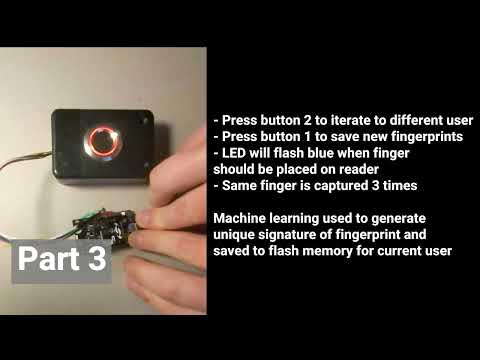

In [1]:
from IPython.lib.display import YouTubeVideo

YouTubeVideo('RD_K1UA_Sp8', width='800', height='500')

## Overview

### Objectives

After completing this tutorial, you will have:
1. A better understanding of how machine learning may be used to generate unique signatures
2. The tools needed to create a fingerprint dataset
3. All of the tools needed to develop your own signature generation machine learning model
4. A working demo to authenticate fingerprints

### Content

This tutorial is divided into the following sections:
1. [Overview of how to generate a unique signature using machine learning](#signature-generation-machine-learning-model-overview)
2. [Creating the dataset](#creating-the-dataset)
3. [Creating the model](#creating-the-model)
4. [Evaluating the model](#evaluating-the-model)
5. [Running the model](#running-the-model)

### Running this tutorial from a notebook

For documentation purposes, this tutorial was designed to run within a [Jupyter Notebook](https://jupyter.org). 
The notebook can either run locally on your PC _or_ on a remote server like [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb).  

- Refer to the [Notebook Examples Guide](https://siliconlabs.github.io/mltk/docs/guides/notebook_examples_guide.html) for more details
- Click here: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/siliconlabs/mltk/blob/master/mltk/tutorials/fingerprint_authentication.ipynb) to run this tutorial interactively in your browser

__NOTE:__ Some of the following sections require this tutorial to be running locally with a supported embedded platform connected.


### Running this tutorial from the command-line

While this tutorial uses a [Jupyter Notebook](https://jupyter.org), 
the recommended approach is to use your favorite text editor and standard command terminal, no Jupyter Notebook required.  

See the [Standard Python Package Installation](https://siliconlabs.github.io/mltk/docs/installation.html#standard-python-package) guide for more details on how to enable the `mltk` command in your local terminal.

In this mode, when you encounter a `!mltk` command in this tutorial, the command should actually run in your local terminal (excluding the `!`)

## Required Hardware

Some parts of the tutorial requires a supported development board and the [R503 Fingerprint Module](https://www.adafruit.com/product/4651).

See the [Hardware Setup](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/fingerprint_authenticator.html#hardware-setup) section of the Fingerprint Authenticator C++ application for details on how to connect the fingerprint module to the development board. 

__NOTE:__ Only the fingerprint module needs to be connected to the development board. You do _not_ need to build the C++ application from source for this tutorial.

## Install MLTK Python Package

Before using the MLTK, it must first be installed.  
See the [Installation Guide](https://siliconlabs.github.io/mltk/docs/installation.html) for more details.

In [ ]:
!pip install --upgrade silabs-mltk

All MLTK modeling operations are accessible via the `mltk` command.  
Run the command `mltk --help` to ensure it is working.  
__NOTE:__ The exclamation point `!` tells the Notebook to run a shell command, it is not required in a [standard terminal](https://siliconlabs.github.io/mltk/docs/installation.html#standard-python-package)

In [3]:
!mltk --help

Usage: mltk [OPTIONS] COMMAND [ARGS]...

  Silicon Labs Machine Learning Toolkit

  This is a Python package with command-line utilities and scripts to aid the
  development of machine learning models for Silicon Lab's embedded platforms.

Options:
  --version                       Display the version of this mltk package and
                                  exit
  --install-completion [bash|zsh|fish|powershell|pwsh]
                                  Install completion for the specified shell.
  --show-completion [bash|zsh|fish|powershell|pwsh]
                                  Show completion for the specified shell, to
                                  copy it or customize the installation.
  --help                          Show this message and exit.

Commands:
  build                          MLTK build commands
  classify_audio                 Classify keywords/events detected in a...
  classify_image                 Classify images detected by a camera...
  commander            

## Signature Generation Machine Learning Model Overview

Before continuing with this tutorial, it is recommended to review the [MLTK Overview](https://siliconlabs.github.io/mltk/docs/overview.html), which provides an overview of the core concepts used by the this tutorial.

While classification (e.g. predicting if an image contains a cat, dog, or goat) is a common usecase for embedded machine learning, another useful application of machine learning is signature generation.
For example, given a grayscale image of someone's fingerprint, generate a sequence of numbers that are unique to the fingerprint; different images of the same fingerprint should generate a nearly identical sequence of numbers while a different person's fingerprint should generate a different sequence of numbers. The sequence of numbers is called the __signature__ and machine learning is used to create the signature generator.
Two signatures are considered similar if their [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) is below a certain threshold.

This is illustrated as follows:  
![](https://github.com/SiliconLabs/mltk/raw/master/docs/img/fingerprint_signature_overview.png)


__NOTE:__ While this tutorial uses grayscale images of fingerprints, many other sample types (audio, accelerometer, etc.) could theoretically be used as well.


### Siamese Networks

The [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network) machine learning model architecture is used to generate the signatures.

> Siamese Networks are neural networks which share weights between two or more sister networks,
each producing embedding vectors of its respective inputs. In supervised similarity learning, the networks are then trained to maximize the contrast (distance) between embeddings of inputs of different classes, 
while minimizing the distance between embeddings of similar classes, resulting in embedding spaces that reflect the class segmentation of the training inputs. [[1]](https://keras.io/examples/vision/siamese_contrastive/)

A siamese network can be illustrated as follows:  
![](https://miro.medium.com/max/700/1*0E9104t29iMBmtvq7G1G6Q.png)  
[Siamese network used in Signet](https://arxiv.org/abs/1707.02131)

There are several things to note about this diagram:  
- The top and bottom blocks of the diagram share the _same_ weights and parameters
- The top and bottom blocks are called a "tower" (so the model has two towers)
- Only one of the towers is needed to generate the signature
- The last layer of the tower is a __fully connected__ layer, the output of this layer is the __signature__ generated from the model input
- The number of units (aka neurons) in the last fully connected layer determines the since of the generated signature


Refer to the following links for additional information about siamese networks:
- [Image similarity estimation using a Siamese Network with a contrastive loss](https://keras.io/examples/vision/siamese_contrastive/)
- [A friendly introduction to Siamese Networks](https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942)


## Creating the dataset 

Before training the model, a dataset is required. The dataset should be a collection of fingerprint images captured by the [R503 Fingerprint Module](https://www.adafruit.com/product/4651).

__NOTE:__ Due to privacy concerns, no dataset is provided by this tutorial. You must generate your own dataset using the instructions below.

Recall that the goal of ML model is to generate a sequence of numbers that are similar for the images of the same fingerprint and different for different fingerprints.
Thus, the dataset should have many images of the __same__ fingerprint.

The structure of the dataset might look something like:

```
abs/left/index/1.jpg             - Person "abc", left hand, index finger, image 1
abs/left/index/2.jpg             - Person "abc", left hand, index finger, image 2
abs/left/index/3.jpg             - Person "abc", left hand, index finger, image 3
...
abs/left/thumb/1.jpg             - Person "abc", left hand, thumb, image 1
abs/left/thumb/2.jpg             - Person "abc", left hand, thumb, image 2
abs/left/thumb/3.jpg             - Person "abc", left hand, thumb, image 3
...
```

The goal is to have has many different people and fingerprints as possible. However, it is critical that there are multiple images of the _same_ fingerprint. This way, the ML model can learn the features that make fingerprints similar and different.

### Generating the dataset

To aid the generation of the dataset, the MLTK provides the command: 

```shell
mltk fingerprint_reader <model> --generate-dataset
```

__NOTE:__ To use this command, you must have a locally connected development board with the R503 fingerprint module connected.   
Refer to [Hardware Setup](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/fingerprint_authenticator.html#hardware-setup) for more details.


With the hardware setup, issue the command:

```shell
mltk fingerprint_reader fingerprint_signature_generator --generate-dataset
```

This will guide you through the process of capturing your fingerprints and saving them to your local PC.
After the command completes, repeat the command with as many other peoples' fingers as possible. The larger your dataset, the better your trained model will perform.

__NOTE:__ The command above uses the pre-built model [fingerprint_signature_generator](https://siliconlabs.github.io/mltk/docs/python_api/models/siliconlabs/fingerprint_signature_generator.html). This argument is effectively ignored when using the `--generate-dataset` option.

__WARNING:__ Be sure to backup your dataset directory after adding new samples!

### Data preprocessing

The [R503 Fingerprint Module](https://www.adafruit.com/product/4651) generates 192x192 grayscale images.  
Additional preprocessing is applied to the raw images to help the ML model learn the important features of the images.

The preprocessing algorithm source may be found in [fingerprint_signature_generator_dataset.py](https://github.com/SiliconLabs/mltk/blob/master/mltk/models/siliconlabs/fingerprint_signature_generator_dataset.py)

The following algorithms are used:  
- __Color space balancing__ - This uses simple statistical centering and removes outliers
- __Sharpening__ - This applies 2D convolution using a harpening filter: `original + (original ? blurred) Ã— amount`
- __Quality rejection__ - Using simple heuristics, if the image is found to be too blurry it is dropped

__NOTE:__ These algorithms are used to preprocess the training dataset _and_ on the embedded device at runtime (see [data_preprocessor.cc](https://github.com/SiliconLabs/mltk/blob/master/cpp/shared/apps/fingerprint_authenticator/data_preprocessor.cc))

### Generating fingerprint pairs

To train a [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network), __pairs__ of fingerprint images are supplied as inputs to the model.

The image pairs are grouped into two classes:  
- __match__ - Images are of the _same_ fingerprint
- __no-match__ - Images are of _different_ fingerprints

The [fingerprint_signature_generator_dataset.py](https://github.com/SiliconLabs/mltk/blob/master/mltk/models/siliconlabs/fingerprint_signature_generator_dataset.py) script is used to generate the image pairs from the fingerprint dataset. 

## Creating the Model

The [model specification](https://siliconlabs.github.io/mltk/docs/guides/model_specification.html) used by this tutorial may be found on Github: [fingerprint_signature_generator.py](https://github.com/siliconlabs/mltk/blob/master/mltk/models/siliconlabs/fingerprint_signature_generator.py).

### Dataset

Due to privacy concerns, no dataset is provided by this tutorial. You must generate your own dataset using the instructions in this tutorial.

Once the dataset is generated, update the model specification script:

```python
# NOTE: For privacy purposes, no dataset is provided for this model.
#       As such, you must generate your own dataset to train this model.
#       Refer to this model's corresponding tutorial for how to generate the dataset.
DATASET_ARCHIVE_URL = 'your-fingerprint-dataset-directory-or-download-url'
#DATASET_ARCHIVE_URL = '~/.mltk/fingerprint_reader/dataset'
```

And modify `DATASET_ARCHIVE_URL` point to your dataset directory or download URL.

### Loss Function

As per the Keras tutorial: [Image similarity estimation using a Siamese Network with a contrastive loss](https://keras.io/examples/vision/siamese_contrastive/), a __contrastive loss__ function is used for model training.

The source code for the custom loss function may be found on Github: [mltk/core/keras/losses.py](https://github.com/siliconlabs/mltk/blob/master/mltk/core/keras/losses.py)

The basic formula for contrastive loss is:  
```
Contrastive loss = mean( (1-true_value) * square(prediction) + true_value * square( max(margin-prediction, 0) ))
```

Where `margin` defines the baseline for distance for which pairs should be classified as dissimilar.

### Model Parameters

Recall that any preprocessing that is done to the data at training time must also be done at runtime on the embedded device.
So, the __exact__ parameters and algorithms used for color balancing and image sharpening must also be used on the embedded device.

To aid with this, the MLTK allows for embedding [model parameters](https://siliconlabs.github.io/mltk/docs/guides/model_parameters.html) into the generated `.tflite` model file that is programmed onto the embedded device.

These parameters are set by the model python script, e.g.:

```python
# The maximum "distance" between two signature vectors to be considered
# the same fingerprint
# Refer to the <model log dir>/eval/h5/threshold_vs_accuracy.png
# to get an idea of what this valid should be
my_model.model_parameters['threshold'] = 0.22

# Also add the preprocessing settings to the model parameters
preprocess_params = my_model.dataset.preprocess_params
my_model.model_parameters['sharpen_filter'] = my_model.dataset.sharpen_filter.flatten().tobytes()
my_model.model_parameters['sharpen_filter_width'] = my_model.dataset.sharpen_filter.shape[1]
my_model.model_parameters['sharpen_filter_height'] = my_model.dataset.sharpen_filter.shape[0]
my_model.model_parameters['sharpen_gain'] = my_model.dataset.sharpen_gain
my_model.model_parameters['balance_threshold_max'] = preprocess_params['balance_threshold_max']
my_model.model_parameters['balance_threshold_min'] = preprocess_params['balance_threshold_min']
my_model.model_parameters['border'] = preprocess_params['border']
my_model.model_parameters['verify_imin'] = preprocess_params['verify_imin']
my_model.model_parameters['verify_imax'] = preprocess_params['verify_imax']
my_model.model_parameters['verify_full_threshold'] = preprocess_params['verify_full_threshold']
my_model.model_parameters['verify_center_threshold'] = preprocess_params['verify_center_threshold']
```

And then read by the firmware application at runtime: [data_preprocessor.cc](https://github.com/SiliconLabs/mltk/blob/master/cpp/shared/apps/fingerprint_authenticator/data_preprocessor.cc)



### Saving the model

The trained Siamese network contains two "towers", however, only one of the towers is required to generate the signature.

Thus, after model training, but before the model is saved, the model is modified so that only one of the towers is saved.
This is done using the `on_save_keras_model` [TrainMixin](https://siliconlabs.github.io/mltk/docs/python_api/core/mltk_model.html#trainmixin) property.

```python
def my_keras_model_saver(
    mltk_model:MyModel,
    keras_model:KerasModel,
    logger:logging.Logger
) -> KerasModel:
    """This is invoked after training successfully completes
    
    Here want to just save one of the "towers"
    as that is what is used to generate the fingerprint signature
    on the device
    """
    # The given keras_model contains the full siamese network
    # Save it to the model's log dir
    h5_path = mltk_model.h5_log_dir_path
    siamese_network_h5_path = h5_path[:-len('.h5')] + '.siamese.h5'
    logger.debug(f'Saving {siamese_network_h5_path}')
    keras_model.save(siamese_network_h5_path, save_format='tf')

    # Extract the embedding network from the siamese network
    embedding_network = None
    for layer in keras_model.layers:
        if layer.name == 'model':
            embedding_network = layer
            break
    if embedding_network is None:
        raise RuntimeError('Failed to find embedding model in siamese network model, does the embedding model have the name "model" ?')

    # Save the tower as the .h5 model file for this model
    logger.debug(f'Saving {h5_path}')
    embedding_network.save(h5_path, save_format='tf')

    # Return the keras model
    return embedding_network

my_model.on_save_keras_model = my_keras_model_saver
```

### Train the model

With the dataset and model specification script ready, it's time to train the model.

This can be done with the command:

```
mltk train fingerprint_signature_generator
```

__NOTE:__ Replace `fingerprint_signature_generator` with the name of your model.

## Evaluating the model

After training completes, the model is automatically evaluated. This is done using a custom evaluation function:

```python
def my_model_evaluator(
    mltk_model:MyModel, 
    built_model:Union[KerasModel, TfliteModel],
    eval_dir:str,
    logger:logging.Logger,
    show:bool
) -> EvaluationResults:
    """Custom callback to evaluate the trained model
    
    The model is effectively a classifier, but we need to do
    a special step to compare the signatures in the dataset.
    """
    results = ClassifierEvaluationResults(
        name=mltk_model.name,
        classes=mltk_model.classes
    ) 

    threshold = my_model.model_parameters['threshold']
    logger.error(f'Using model threshold: {threshold}')

    y_pred, y_label, y_dis = generate_predictions( 
        mltk_model,
        built_model,
        threshold
    )

    results.calculate(
        y=y_label,
        y_pred=y_pred,
    )

    results.generate_plots(
        logger=logger, 
        output_dir=eval_dir, 
        show=show
    )

    match_dis = []
    nomatch_dis = []

    for y, dis in zip(y_label, y_dis):
        if y == 0:
            match_dis.append(dis)
        else:
            nomatch_dis.append(dis)

    match_dis = sorted(match_dis)
    match_dis_x = [i for i in range(len(match_dis))]
    nomatch_dis = sorted(nomatch_dis)
    nomatch_dis_x = [i for i in range(len(nomatch_dis))]

    step = (match_dis[-1] - match_dis[0]) / 100
    thresholds = np.arange(match_dis[0], match_dis[-1], step)

    match_acc = []
    nomatch_acc = []

    for thres in thresholds:
        valid_count = sum(x < thres for x in match_dis)
        match_acc.append(valid_count / len(match_dis))
        valid_count = sum(x > thres for x in nomatch_dis)
        nomatch_acc.append(valid_count / len(nomatch_dis))

    fig = plt.figure('Threshold vs Accuracy')

    plt.plot(match_acc, thresholds, label='Match')
    plt.plot(nomatch_acc, thresholds, label='Non-match')

    #plt.ylim([0.0, 0.01])
    plt.legend(loc="lower right")
    plt.xlabel('Accuracy')
    plt.ylabel('Threshold')
    plt.title('Threshold vs Accuracy')
    plt.grid(which='major')

    if eval_dir:
        output_path = f'{eval_dir}/threshold_vs_accuracy.png'
        plt.savefig(output_path)
        logger.info(f'Generated {output_path}')
    if show:
        plt.show(block=False)
    else:
        fig.clear()
        plt.close(fig)
    

    fig = plt.figure('Euclidean Distance')

    plt.plot(match_dis_x, match_dis, label='Match')
    plt.plot(nomatch_dis_x, nomatch_dis, label='Non-match')

    plt.legend(loc="lower right")
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.title('Euclidean Distance')
    plt.grid(which='major')

    if eval_dir:
        output_path = f'{eval_dir}/eclidean_distance.png'
        plt.savefig(output_path)
        logger.info(f'Generated {output_path}')
    if show:
        plt.show(block=False)
    else:
        fig.clear()
        plt.close(fig)

    return results


my_model.eval_custom_function = my_model_evaluator
```

This uses the model's validation dataset to generate pairs of matching and non-matching fingerprint images.
Each image from the pair is given to the trained model (recall that only one "tower" of the Siamese network is saved, thus the model only has one input) and its corresponding signature is generated.

The euclidean distance is then calculated between the two signatures. If the distances is less than a threshold (which is specified in the [model parameters](#model-parameters)) then the two images are considered a match, otherwise they are considered a non-match.

The model predictions are then compared against the actual values to generate the various classification evaluation metrics.


### Determining the threshold

The model threshold parameter must be determined before we can deploy this model.
The model threshold is effectively the maximum euclidean distance between two signatures for them to be considered the same. e.g.:

```
IF distance(signature1, signature2) < threshold THEN
   Signatures are from the same fingers
ELSE
   Signatures are from different fingers
```

The MLTK evaluation scripts allow for determining this value.

After the evaluation completes, various diagrams are generated in the model's log directory (the actual directory path is printed to the console, e.g.: `~/.mltk/models/fingerprint_signature_generator/eval/h5/`).

One such diagram is:

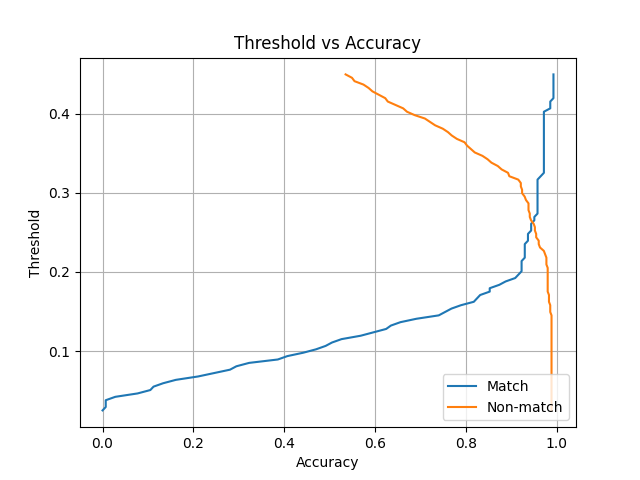

In [5]:
from IPython.display import Image
from mltk.utils.path import fullpath

Image(filename=fullpath('~/.mltk/models/fingerprint_signature_generator/eval/h5/threshold_vs_accuracy.png')) 

This diagram compares the threshold versus the model's accuracy for each class.

__NOTE:__ Different diagrams will be generated for different fingerprint datasets and model parameters.

So, from the diagram, if the threshold was set to 0.2, then the model would:  
- Correctly identify two matching fingerprints about 91% of the time
- Correctly identify two non-matching fingerprints about 97% of the time

If the threshold was set to 0.1, then the model would:  
- Correctly identify two matching fingerprints about 45% of the time
- Correctly identify two non-matching fingerprints about 98% of the time

Since the intent of this application is to authenticate users, we want the non-match accuracy to be as high as possible,
while at the same time have a reasonably high match accuracy:
- __Non-match accuracy__ - The higher this is, the better the application rejects hackers from spoofing fingerprints
- __Match accuracy__ - The higher this is, the better the user-experience when using the application


The threshold value is set in the model specification python script, e.g.:

```python
# The maximum "distance" between two signature vectors to be considered
# the same fingerprint
# Refer to the <model log dir>/eval/h5/threshold_vs_accuracy.png
# to get an idea of what this valid should be
my_model.model_parameters['threshold'] = 0.22
```

After updating the threshold, re-run the model evaluation with the command:

```
mltk evaluate fingerprint_signature_generator

Name: fingerprint_signature_generator
Model Type: classification
Overall accuracy: 95.469%
Class accuracies:
- no-match = 97.465%
- match = 92.982%
Average ROC AUC: 96.277%
Class ROC AUC:
- no-match = 97.308%
- match = 95.245%
```

__NOTE:__ Replace `fingerprint_signature_generator` with the name of your model.

## Running the model

Now that we have a trained model, it is time to run it in on an embedded device.

There are several different ways this can be done:

### Using the command-line

The MLTK features the command:  
```
mltk fingerprint_reader --help
```
Which will load the trained fingerprint model and execute it on the embedded device.

__NOTE:__ Additional hardware is required to run this command, see [Hardware Setup](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/fingerprint_authenticator.html#hardware-setup)


To run program your model to an embedded device, issue the command:  
```
mltk fingerprint_reader fingerprint_signature_generator --accelerator MVP
```

__NOTE:__ Replace `fingerprint_signature_generator` with the name of your model.

Which will program the [fingerprint_authenticator](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/fingerprint_authenticator.html) application and your model to the embedded device and run.

This command will also display images of the fingerprints captured from the fingerprint module.

### Building the C++ example application

The MLTK supports building [C++ Applications](https://siliconlabs.github.io/mltk/docs/cpp_development/index.html).

It also features an [fingerprint_authenticator](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/fingerprint_authenticator.html) C++ application
which can be built using:  
- [Visual Studio Code](https://siliconlabs.github.io/mltk/docs/cpp_development/vscode.html) 
- [Simplicity Studio](https://siliconlabs.github.io/mltk/docs/cpp_development/simplicity_studio.html)
- [Command Line](https://siliconlabs.github.io/mltk/docs/cpp_development/command_line.html)

Refer to the [fingerprint_authenticator](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/fingerprint_authenticator.html) application's documentation
for how include your model into the built application.